# Lead role preprocessing

A very important piece of information to validate our hypothesis, but one that is very difficult to obtain, is the importance of the actors' roles within each movie. To get reliable information on this, we looked at the free public data available and found the script data for the most directly relevant movies. Our goal is to compute how much of a role each character plays, given the movie plot data we have and the names of the characters in each movie. As a first step, we prepared a script that would be our gold label, from which we calculated the percentage of each character in the movie. We used this script and mapped it to the plot to train and validate our AI model.

## 1. Script crawling

To crawl the scripts, we selected https://imsdb.com and wrote a crawler for it. As the site is very old, the templates between the script documents are very different, and the crawling difficulty is high.

### A. Downloading the scripts
 
```bash
python Preprocessing/script_crawling/get_script_urls.py
```
Running the script above will produce scripts_urls.json, which contains meta information of urls we are going to crawl.

In [245]:
import requests
from bs4 import BeautifulSoup
import os
from urllib.parse import quote
from tqdm.notebook import tqdm
import json
from collections import defaultdict
import re
import pandas as pd
from pathlib import Path
root_path = Path('../')

In [370]:
scripts_urls= json.load(open('scripts_urls.json'))
print(f"Total number of script: {len(scripts_urls)}")
print(f"Scripts with release date field : {len([ x for x in scripts_urls if 'release_date' in x])} ")
print(f"\twith script date field: {len([ x for x in scripts_urls if 'script_date' in x])} ")

Total number of script: 1187
Scripts with release date field : 641 
	with script date field: 677 


Since our movie data doens't have any movie identifier, it's release date is very important feature to map movie with tmdb data with high accuracy.

Running **download_scripts.py** will produce url2pairs.json, which has beautifulsoup object that contain complex web component including our target scripts.

In [13]:
url2pairs = json.load(open('url2pairs.json'))

# Processing scripts
## step 1. Mapping TMDB Movie id by using movie name, year

```bash
python Preprocessing/script_crawling/scripts_tmdb_matching.py
```
Run above code will generate mapping of movies to TMDB, *scripts_urls.json*. TMDB search API will retuen several movies when we send the movie name as query. Among the results, we eliminated all but one sample that exactly fulfills the year condition. If released_year exists, use it as top prioroty. If not, pick closer to script_date, but after script_date.

In [110]:
manual_matching = json.load(open('manual_matching.json')) # handcrafted feature. Was so painful..

In [197]:
scripts_urls = json.load(open('tmdb_matched_scripts_urls.json','w')) # total 1060 sample matched.

## step 2. matching movie plots.
```bash
python Preprocessing/movie_plot_join.py
```
Executing the script above will produce *tmdb_id2plot.json*, a mapper with the movie plot from diverse sources and tmdb_id.
we have three major sources for the movie plots.
1. Our original CMU plot data. https://www.cs.cmu.edu/~ark/personas/
2. MPST movie plot. https://www.kaggle.com/datasets/cryptexcode/mpst-movie-plot-synopses-with-tags
3. Wikipedia movie plot. https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots

CMU data has freedase id, MPST data has imdb id, and wikipedia plot has only the name. So the priority is MPST > CMU > Wikipedia plot.

valid matching by mpst: 942

valid matching by cmu: 917

union to mpst is : 1011

additional backups from wiki data : 30

We have total : 1041

In [372]:
tmdb_id2plot = json.load(open('tmdb_id2plot.json'))

## Step 3. Parsing character's script
Strategy : map script's speaker to tmdb character list.

#### Classification rule
**Count the number of space or '\t' in front of the line.**

Assumption : **same type of instruction will share same indent in a single script.**

Final schema of matched scripts
```json
tmdb_id2matched_scripts = {
    tmdb_id: {
        'scripts': [{
            'tmdb_credit': tmdb_credit_obj,
            'portion': float,
            'spoken_syllables': int,
            'num_script': int,
            'script_text': {
                1: "1st script. order starts from 1.",
                }
            }
        ],
        'statistics': {
            'total_spoken_syllables': int,
            'total_spoken_words': int,
            'original_character_count': int,
            'matched_character_count': int,
        },
        'url': str
    }
}
```

## Step 4. Calculating each character's share of the overall script
Estimate speaking time by the number of syllables in each sentense.


# Training model
## 1. Training Setting (Problem Definition)
Input: f"Estimate the portion of {character} in float form from this plot:{plot}"

Output: float(0~1)


In [2]:
import json
tmdb_id2matched_scripts = json.load(open('tmdb_id2matched_scripts.json'))
tmdb_id2plot = json.load(open('tmdb_id2plot.json'))
print(f"Total script num: {len(tmdb_id2matched_scripts.keys())}")
print(f"Total actors num: {sum([len(x['scripts']) for x in tmdb_id2matched_scripts.values()])}")

Total script num: 942
Total actors num: 13760


split train : eval : test = 8:1:1

In [380]:
scripts_in_sets = json.load(open('plot_portion_dataset.json'))
for k, v in scripts_in_sets.items():
    print(f"{k.title()} Set: {len(v)}\n\tUnique docs: {len(list(set([i['tmdb_id'] for i in v])))}\n")

Train Set: 11668
	Unique docs: 709

Evaluation Set: 792
	Unique docs: 94

Test Set: 791
	Unique docs: 94



Now, prepare dataset for machine learning.

Prompt: ""Predict the percentage of a movie's plot that a character takes up.\nCharacter: {} \nPlot: ""

## 2. Implement LLM models benchmark
### a. Fine-tuning T5
- T5-large : Trainable. 

with T5-large, we finetuned t5-large model on total 11668 datapoint for one epoch.
```python
f"Predict the percentage of a movie's plot that a character takes up.\nCharacter: {character_name} \nPlot: {plot}"
```

### b. Instruction tuned-LLM

API inference available:
- ChatGPT-3.5
- ChatGPT-4

While chatGPT, force model generation with json format and request estimate the portion of all characters at once. In case of chatgpt failure, when it does not return value for requested field, replace it with linear regression model predicted output.

### c. Heuristic baseline
- order field in tmdb_credit: the order in credit data of tbdb correlates with his/her importance. 
- linear regression tuned on order: Fit simple linear regression with order as single feature.
- counting character_name on plot

Obtained Simple Linear regression models
```python
def get_portion_by_order_logscale(order):
    return np.power(np.e, 0.7756578 - 0.04791 * order)

def get_portion_by_order(order):
    return max(5.689275 - 0.122673 * order, 0.001)
```

## 3. Comparison and Model selection
For the fare comparison of the model, all model's output would be scaled to make sum of all portions in single plot would be 100.

Correlation with gold label, accuracy and f1 score for leading role prediction of threshould 10% will be used as evaluation crietria.

In [340]:
validation_set = json.load(open(root_path / 'Preprocessing/plot_portion_dataset.json'))['evaluation']
validation_pred = {model_name: defaultdict(dict) for model_name in ['linear','log-linear','tmdb_order','T5-large','ChatGPT-3.5','ChatGPT-4']}
tmdb_id2credit = json.load(open(root_path / 'Data/tmdb_resources/tmdb_id2credit_full.json'))
target_tmdb_ids = set([v['tmdb_id'] for v in validation_set])

### Heuristics, simple model

In [341]:
import numpy as np
def get_portion_by_order_logscale(order): # load as a backup method
    return np.power(np.e, 0.7756578 - 0.04791 * order)

def get_portion_by_order(order):
    return max(5.689275 -0.122673 * order, 0.001)

def get_order(tmdb_id, actor_id):
    credit = tmdb_id2credit[str(tmdb_id)]
    for j in credit['cast']:
        if str(j['id']) == str(actor_id):
            return j['order']
    raise ValueError('invalid actor')

def scaling(portions):
    total_portions = sum(list(portions.values())) + 0.0001
    return {k: 100*v / total_portions for k,v in portions.items()}

In [353]:
for tmdb_id in target_tmdb_ids:
    credit = tmdb_id2credit[tmdb_id]
    portions_ll = {}
    portions_l = {}
    portions_o = {}
    for c in credit['cast']:
        portions_ll[str(c['id'])] = get_portion_by_order_logscale(c['order'])
        portions_l[str(c['id'])] = get_portion_by_order(c['order'])
        portions_o[str(c['id'])] = c['order']
    validation_pred['log-linear'][tmdb_id] = scaling(portions_ll)
    validation_pred['linear'][tmdb_id] = scaling(portions_l)
    validation_pred['tmdb_order'][tmdb_id] = scaling(portions_o)

### GPT-3.5 & GPT-4
To compare with 
```python
prompt = f"""Estimate the percentage of the script that each character represents from the movie plot.
[Characters]: {characters_str}
[Plot]: {eval_tmdb_id2s[tmdb_id][0]['plot']}

Estimate the percentage of the script that each character represents from the movie plot mentioned above. Return the portion of every character in a JSON dictionary, with the character name as key and portion as value."""
```


In [354]:
chatgpt_pred = json.load(open('chatgpt_pred.json'))
chatgpt_pred_4 = json.load(open('chatgpt_4_pred.json'))

In [355]:
def hash_string(text):
    return text.lower().replace(' ','')
def name_match_and_get(tmdb_id,character_id,original_name,generated_dict):
    hashed_dict = {hash_string(k):v for k,v in generated_dict.items()}
    if hash_string(original_name) in hashed_dict:
        try:
            return float(str(hashed_dict[hash_string(original_name)]).replace('<','').replace('%','').strip())
        except:
            return get_portion_by_order_logscale(get_order(tmdb_id,character_id))
    return get_portion_by_order_logscale(get_order(tmdb_id,character_id))

In [356]:
for tmdb_id,v in chatgpt_pred.items():
    output_parsed = json.loads(v['gen_text'])
    parsed_prob = {}
    for character, c_id in v['character2id'].items():
        parsed_prob[c_id] = name_match_and_get(tmdb_id,str(c_id),character,output_parsed)
    prob_sum = sum(list(parsed_prob.values()))
    validation_pred['ChatGPT-3.5'][tmdb_id] = scaling(parsed_prob)

In [357]:
for tmdb_id,v in chatgpt_pred_4.items():
    try:
        output_parsed = json.loads(v['gen_text'])
    except:
        output_parsed = {}
    parsed_prob = {}
    for character, c_id in v['character2id'].items():
        parsed_prob[c_id] = name_match_and_get(tmdb_id,c_id,character,output_parsed)
    validation_pred['ChatGPT-4'][tmdb_id] = scaling(parsed_prob)

### T5

In [358]:
t5_output = json.load(open('lead_role_inference/t5_validation_inference.json'))
for key, pred in t5_output.items():
    tmdb_id, actor_id = key.split('__')
    validation_pred['T5-large'][str(tmdb_id)][str(actor_id)]=float(pred['output_text'])
for tmdb_id in target_tmdb_ids:
    credit = tmdb_id2credit[tmdb_id]
    for c in credit['cast']:
        if str(c['id']) not in validation_pred['T5-large'][tmdb_id]:
            validation_pred['T5-large'][tmdb_id][str(c['id'])] = get_portion_by_order_logscale(c['order'])
    validation_pred['T5-large'][tmdb_id] = scaling(validation_pred['T5-large'][tmdb_id])

In [359]:
json.dump(validation_pred,open('validation_pred.json','w'))

### stats

In [360]:
corr_dict = defaultdict(list)
for v in validation_set:
    for model, lookup in validation_pred.items():
        corr_dict[model].append(lookup[v['tmdb_id']][str(v['character_id'])])
    corr_dict['Y'].append(v['portion'])
pd.DataFrame(corr_dict).corr()[['Y']].T

,linear,log-linear,tmdb_order,T5-large,ChatGPT-3.5,ChatGPT-4,Y
Y,0.372206,0.486409,-0.307976,0.7577,0.777683,0.828316,1.0


In [383]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
result_dict = corr_dict.copy()
def classify_scores(scores):
    return [1 if score > 10 else 0 for score in scores]

for k,v in result_dict.items():
    result_dict[k] = classify_scores(v)

Models = []
ACC = []
F1 = []
AUC = []
for model_name, model_predictions in result_dict.items():
    if model_name not in  ['Y','tmdb_order']:
        Models.append(model_name)
        ACC.append(accuracy_score(result_dict['Y'], model_predictions))
        F1.append(f1_score(result_dict['Y'], model_predictions))
        AUC.append(roc_auc_score(y_true_classified, model_predictions))

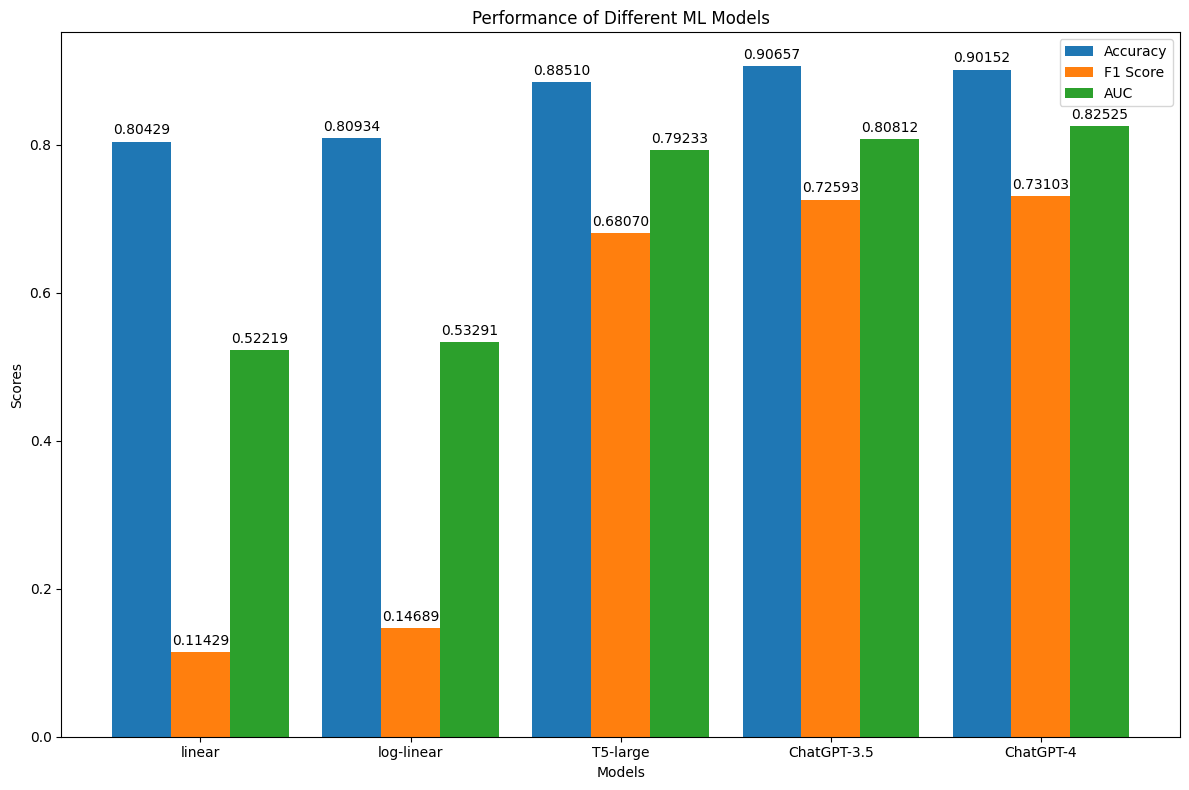

In [384]:
import matplotlib.pyplot as plt

x = np.arange(len(models))  # the label locations

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.28  # the width of the bars

rects1 = ax.bar(x - bar_width, ACC, bar_width, label='Accuracy')
rects2 = ax.bar(x, F1, bar_width, label='F1 Score')
rects3 = ax.bar(x + bar_width, AUC, bar_width, label='AUC')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance of Different ML Models')
ax.set_xticks(x)
ax.set_xticklabels(Models)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.5f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()